# Generating saliency maps

This notebook shows how we find important factors for trained COVID-19 Radiograph models using saliency maps.

In [1]:
# Import dependencies
import torch

from models import CXRClassifier
from datasets import PadChestDataset

import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

/homes/gws/jjanizek/anaconda3/envs/new_torch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


### Load a trained model

In [2]:
## obviously you'll want to replace this with the path to your own saved model
model_path = '/projects/leelab3/covid-cxr-models/bimcvpadchest.densenet121.30493.pkl.best_auroc'

classifier = CXRClassifier()
classifier.load_checkpoint(model_path)

### Generate feature attributions using Expected Gradients

To generate feature attributions, we use the [Expected Gradients method](https://arxiv.org/abs/1906.10670). This is similar to the popular [Integrated Gradients method](https://arxiv.org/abs/1703.01365), but replaces the single reference sample of Integrated Gradients with a full background reference distribution. The Expected Gradients attribution ($\phi$) for a model $f$, a radiograph $x$, and a pixel $i$, is given as:

$$ \phi_i (f,x) =  \mathbb{E}_{\alpha \sim U(0,1), x' \sim D} \bigg[ (x_i - x_i') \frac{ \partial f(x' + \alpha \times (x-x')}{\partial x_i} \bigg],$$

where $x'$ is a single reference sample drawn from $D$, a distribution of background references. [This article](https://distill.pub/2020/attribution-baselines/) goes into more depth explaining why using a full background reference is desirable. Intuitively, however, it suffices to understand that "more important" pixels will receive larger magnitude attributions.

In [3]:
##
## The full repository for Expected Gradients can be found here: https://github.com/suinleelab/path_explain
## but for ease of use, we've included the PyTorch implementation in a utils file in this repo
##

from utils import PathExplainerTorch

In [4]:
##
## Initialize the explainer with the trained classifier
##

pet = PathExplainerTorch(classifier.model.cpu())

We generate the background references $D$ using COVID-19 negative images from the PadChest dataset

In [5]:
padchest_train_ds = PadChestDataset(fold='train', labels='ChestX-ray14',random_state=30493)
background_ds = torch.zeros(200,3,224,224)
for i,x in enumerate(padchest_train_ds):
    background_ds[i,:,:,:] = x[0]
    if i == 199:
        break

/homes/gws/jjanizek/anaconda3/envs/new_torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


We pick an image from the test set to explain the model's decision

In [6]:
padchest_test_ds = PadChestDataset(fold='test', labels='ChestX-ray14',random_state=30493)

x = padchest_test_ds[6]

example = x[0].view(1,3,224,224)
example.requires_grad = True

label = x[1]

odds = np.exp(classifier.model(example)[0][14].detach().numpy().item())
probs = odds/(1+odds)

We run the explainer to generate attributions. The "output_indices" argument chooses an output that we want to explain the model with respect to. Our model is a multi-label model, where each radiograph can be classified as having any subset of the ChestXray-14 pathology labels + COVID-19.

In [7]:
output_attribs = pet.attributions(example,background_ds,output_indices=torch.tensor([14]),use_expectation=True,num_samples = 200)
##
## for visualization purposes, we take the mean absolute EG values 
## (variable named "shaps" here because EG calculates an Aumann-Shapley value)
##
ma_shaps = output_attribs.abs().mean(0).mean(0).detach().numpy()

### Visualize attributions

In [8]:
## load custom colormap 
from utils import monotonically_increasing_red

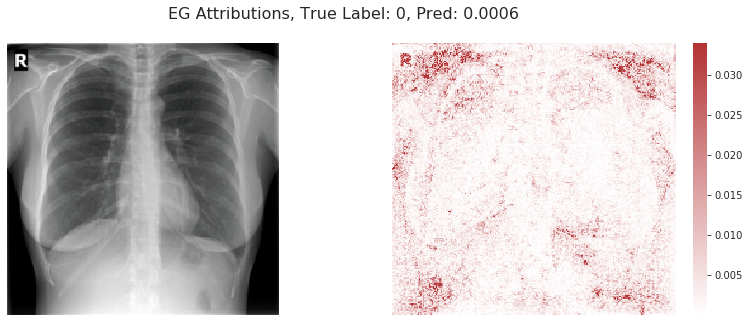

In [9]:
sb.set_style("white")
fig, (showcxr,heatmap) = plt.subplots(ncols=2,figsize=(14,5))
hmap = sb.heatmap(ma_shaps,
        cmap = monotonically_increasing_red(),
        linewidths=0,
        zorder = 2,
        vmax = np.percentile(ma_shaps.flatten(), 99.5) ## we clip attributions at 99.5th percentile
        )                                              ## to fix Coverage (see http://ceur-ws.org/Vol-2327/IUI19WS-ExSS2019-16.pdf)
cxr=example.detach().numpy().squeeze().transpose(1,2,0)    
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
cxr = std * cxr + mean
cxr = np.clip(cxr, 0, 1)

hmap.axis('off')

showcxr.imshow(cxr)
showcxr.axis('off')
fig.suptitle('EG Attributions, True Label: {:d}, Pred: {:0.4f}'.format(label[14],probs), fontsize=16)
plt.show()

We can see that the attributions highlight the big "R" as well as the shoulder regions of the image